<a href="https://colab.research.google.com/github/stevenguyen72/CBDRobotic-internship/blob/master/Week_1/Assignment6_Fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Memory + GPU hacking

## Memory Information

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.58GB
Used: 603.61MB
Percentage: 3.6%


## GPU Information

In [2]:
!nvidia-smi

Wed Dec 30 02:00:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Download Dataset

In [2]:
!pip install kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [5]:
!kaggle datasets download "moltean/fruits"

 99% 753M/760M [00:19<00:00, 37.8MB/s]
100% 760M/760M [00:19<00:00, 39.9MB/s]


In [6]:
!unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg

#Working

##Import library

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import *
import numpy as np
import shutil
import json

In [ ]:
# shutil.rmtree('/content/fruits-360/')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
tf.test.is_built_with_cuda()

True

##Preprocessing Image

`featurewise_center`:`boolean` make input mean = 0, need to fit first (didnt test)

`rotation_range`: `int`. set in range (0,360) to rotate image

`width_shift_range`: move image to left or right randomly. in this case, `20` is quite good (see image below)

`heigh_shift_range`: move image to up or down randomly

`brightness_range` : int range, after few testing, (1,2) is quite ok since a image is not too bright or too shadow

`shear_range`: use for scretch image. in this case, we won't use this because the shape of fruit is something like an important feature to vertify class, we shouldn't make model confuse about this.

`zoom_range`: whether zoom image or not. we can give a range scale value like [0.7, 1.3]. but also can give a single `int` value. model will know like [1-`int`, 1+`int`]

`horizontal_flip`:`boolean` whether mirror respect to horizontal or not

`vertical_flip`:`boolean` whether mirror respect to vertical or not

`rescale_flip`: `int` very important because we should rescale image to range (1/255,1) for faster and robust training.

`validation_split`: `int` validation set split. for example, if we want to split data into 90% train and 10% val set `validation_split`= 0.1. but when we call `DirectoryIterator`, we need to pass `subset` to either `trainning` or `validation`

`dtype`: type of data


In [7]:
train_datagen = preprocessing.image.ImageDataGenerator(
    featurewise_center=False, # chỉnh mean của input = 0, có tác dụng khi fit model
    samplewise_center=False,
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06, 
    rotation_range=360, # xoay ảnh
    width_shift_range=20, # dịch hình ảnh sang trái hoặc phải
    height_shift_range=20, # dịch hình ảnh lên trên hoặc dưới
    brightness_range=(1,2), # chỉnh độ sáng ảnh từ range (1,2)
    shear_range=0, # kéo dài hình ảnh
    zoom_range=[0.7, 1.3], # độ zoom từ range [0.7, 1.3]
    channel_shift_range=5, 
    fill_mode='nearest', 
    cval=0.0,
    horizontal_flip=True, # mirror theo horizontal
    vertical_flip=True, # mirror theo vertical
    rescale=1/255, # rescall giá trị input
    preprocessing_function=None, 
    data_format=None, 
    validation_split=0.1, # 0.1 nghĩa là có 0.1 là bộ validate, chọn bộ train / validate trong `DirectoryIterator` subset = 'training' hoặc 'validation`
    dtype=None
)

DirectoryIterator
`directory`: path of training dataset

`imageiterator`: image iterator we defined early

`target_size`: we can define input size to model here

`color_mode`: usually `rgb`, other option is `rgba`, `grayscale`.

`classes`: `list`: structure of list is : "category_name" : "image" . if set to None, function will auto create class base on directory structure.
basically directory structure will be:
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Database</b>
|__ <b>class_1</b>
    |______ <b>img_1</b>
    |______ <b>img_2</b>
|__ <b>class_2</b>
    |______ <b>img_1</b>
    |______ <b>img_2</b>
|__ <b>class_3</b>
    |______ <b>img_1</b>
    |______ <b>img_2</b>
</pre>

`class_mode`: `boolean` if output is a boolean, if we have many output, set to `categorical`

`batchsize`: size of single batch, usually 32. set it lower if we have few RAM 

`suffle`: `boolean` whether random batches per epochs or not. set this param to `True` also random the data at first (before fit it in model)

`seed`: `int` random seed for data suffle. we can use the same `seed` when we initial train set and val set, to perfectly divide these two dataset without having some duplicate samples into both dataset. for example, I used `seed` = 1 for both `train_set` and `test_set`

`data_format`: this param set `channel` in a image to first or last in image matrix. (`channel`, x, x) or (x ,x ,`channel`). highly recommend to set it to `None`

`save_to_dir`: when a image in a class being use, it will automatically save all images of this class to the directory we passed) useful for debugging and testing 

`save_prefix`: `str` name of save image when `save_to_dir` active

`save_format`: format of image when `save_to_dir` active

`subset`: `training` or `validation`. set when `validation_split` active

`interpolation`:

`dtype`: type of database





In [8]:
train_set = preprocessing.image.DirectoryIterator(
    '/content/fruits-360/Training', #
    train_datagen, #
    target_size=(224, 224), #
    color_mode='rgb', #
    classes=None, # nhận dict với keys là one hot, values là tên folder, set = None thì tensor tự động phân loại 
    class_mode='categorical', #
    batch_size=32, #
    shuffle=True, #
    seed=1, #
    data_format=None, # để channel lên đầu hoặc cuối, set default 
    # save_to_dir='/content/drive/MyDrive/CBD_Robotic/fruit-classify/img_test', #
    save_prefix='aug', #
    save_format='png', #
    follow_links=False,
    subset='training', #
    interpolation='nearest', #
    dtype=None 
)

Found 60955 images belonging to 131 classes.


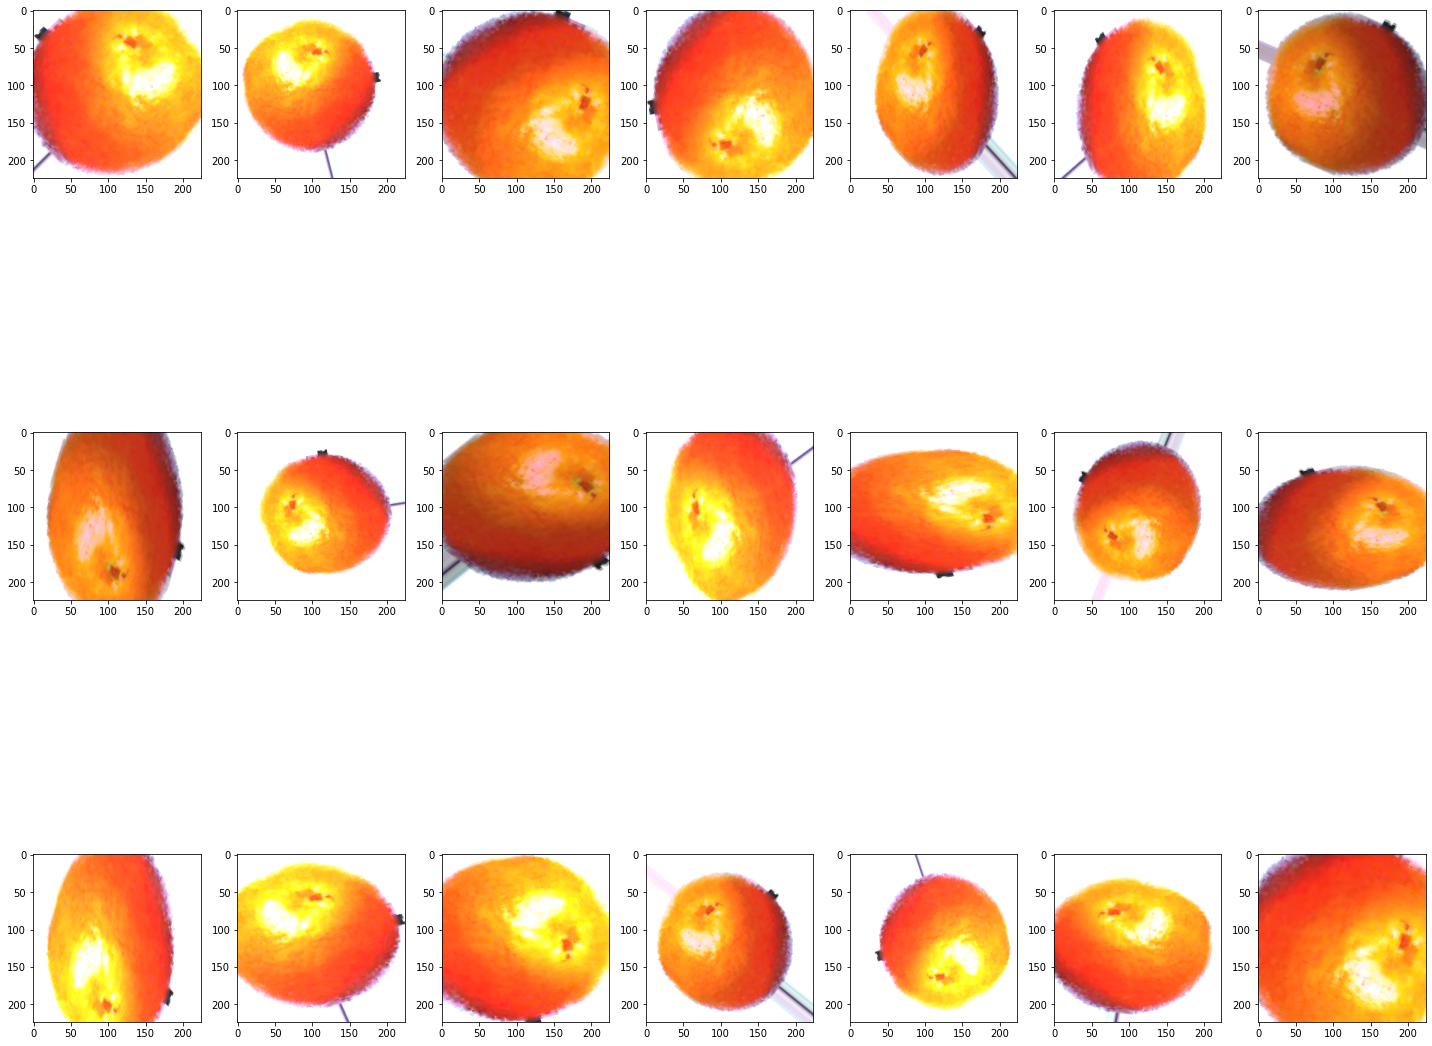

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 7, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

augmented_images = [train_set[0][0][10] for i in range(21)]
plotImages(augmented_images)

In [42]:
val_datagen = preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.1)

In [43]:
val_set = preprocessing.image.DirectoryIterator(
    '/content/fruits-360/Training', 
    train_datagen, 
    target_size=(224, 224),
    color_mode='rgb', 
    classes=None, 
    class_mode='categorical',
    batch_size=32, 
    shuffle=True, 
    seed=1, 
    data_format=None, 
    save_to_dir=None,
    save_prefix='', 
    save_format='png', 
    follow_links=False,
    subset='validation', 
    interpolation='nearest', 
    dtype=None
)

Found 6737 images belonging to 131 classes.


In [44]:
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1/255)

In [45]:
test_set = preprocessing.image.DirectoryIterator(
    '/content/fruits-360/Test', 
    train_datagen, 
    target_size=(224, 224),
    color_mode='rgb', 
    classes=train_set.class_indices, #use classes in train_set
    class_mode='categorical',
    batch_size=32, 
    shuffle=False, 
    seed=None, 
    data_format=None, 
    save_to_dir=None,
    save_prefix='', 
    save_format='png', 
    follow_links=False,
    subset=None, 
    interpolation='nearest', 
    dtype=None
)

Found 22688 images belonging to 131 classes.


In [46]:
# test_set.classes

array([  0,   0,   0, ..., 130, 130, 130], dtype=int32)

In [47]:
# test_set.num_classes

131

##Load Model

In [ ]:
# json_log = open('/content/drive/MyDrive/CBD_Robotic/model/json_log.json', mode='wt', buffering=1)

callbacks:

`earlystopping`: use when we want to stop early. 


1.   `monitor` is what we use to decide.
2.   `min_delta` is the number. if the changing is lower than min_delta, `patience` +=1
3.   `patience`: number of tolerance. if exceeded, early stopping trigged

`learningRateSchedule`: use to manipulate learning rate respect to epoches

1.   `schedule`: we can define a function to deal with epoch and lr. the example below indicate that if epoch > 2, lr will decrease to 0.95 everytime after all epochs that >2
2.   `verbose`:

`ModelCheckpoint`: save model after one epoch. see example below for more details

`TensorBoard`: create tensorboard that have details of model by graph. for more detail. go to tensorflow docs.

`lambdaCallback`: create a customize callback for many purposes, ie: create a function that save values like `loss` and `accuracy` to json file, then close it after end of model...





In [66]:
def schedule(epoch, lr):
  if epoch > 2:
    lr = lr * 0.95
  return lr

In [78]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/CBD_Robotic/model/w_save/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/CBD_Robotic/model/logs'),
    # tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/CBD_Robotic/model/CSVlog.csv'),
    # tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: json_log.write(json.dumps({'epoch': epoch, 'loss': logs['loss']}) + '\n'),
                                      # on_train_end=lambda logs: json_log.close()),
]

##Training model

We will use model ResNet50 with output equal to num_classes of train_set

In [10]:
model = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=None,
    input_shape=None, pooling=None, classes=train_set.num_classes
)

In [11]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [69]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics = ['accuracy'],
            )

In [59]:
# use for continue trainning model, if begin training, just run model.fit

# model = models.load_model('/content/drive/MyDrive/CBD_Robotic/model/w_save/model.05-14.55.h5')


model.fit()

`step_per_epoch`: `int` numbers of step per epochs. set it to fixed numbers like 100... If this param is ignored, function will generate all samples in batches per epoch.

`initial_epoch`: if we set to 10, so model will start train at epoch 10. it is useful for continue trainning model. because model saved have the current number of epoch in its name.

`validation_steps`: we can set it to fixed number. so in 1 epoch, not all samples will used to val. it can cause some very first epochs will have unstable validation accuracy, but set it to small number make model train faster. And if we train for >100 epochs, validation accuracy will become stable. Otherwise, we can just ignore this param, so the model will use all val dataset to valitdate model per epoch.

`callback`: add callback we create before to apply to model



In [82]:
current_epoch = 150 # current epoch, look the number of model
# training model
hist = model.fit(
    train_set,
    steps_per_epoch=100,
    epochs=200, 
    initial_epoch=current_epoch,
    validation_data=val_set,
    validation_steps=100,
    callbacks=my_callbacks,
)

100/100 [==============================] - 89s 897ms/step - loss: 0.0168 - accuracy: 0.9966 - val_loss: 0.0513 - val_accuracy: 0.9859
Epoch 185/200

Epoch 00185: LearningRateScheduler reducing learning rate to 8.824627428793974e-08.
100/100 [==============================] - 89s 895ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0.0499 - val_accuracy: 0.9866
Epoch 186/200

Epoch 00186: LearningRateScheduler reducing learning rate to 8.383396057354275e-08.
100/100 [==============================] - 90s 898ms/step - loss: 0.0225 - accuracy: 0.9937 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 187/200

Epoch 00187: LearningRateScheduler reducing learning rate to 7.964226220735781e-08.
100/100 [==============================] - 90s 900ms/step - loss: 0.0222 - accuracy: 0.9925 - val_loss: 0.0373 - val_accuracy: 0.9859
Epoch 188/200

Epoch 00188: LearningRateScheduler reducing learning rate to 7.566014943449773e-08.
100/100 [==============================] - 89s 892ms/step - loss: 0.

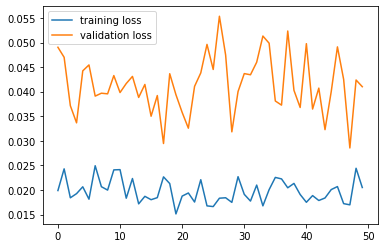

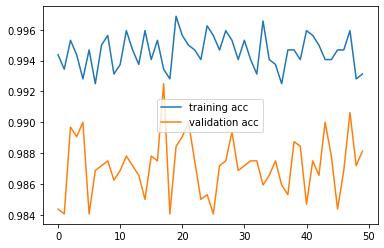

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [84]:
plt.plot(hist.history["loss"], label = "training loss")
plt.plot(hist.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(hist.history["accuracy"], label = "training acc")
plt.plot(hist.history["val_accuracy"], label = "validation acc")
plt.legend()
plt.show()
plt.figure()

In [83]:
model.evaluate(test_set)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


709/709 [==============================] - 312s 440ms/step - loss: 0.0663 - accuracy: 0.9818


[0.06634264439344406, 0.9817965626716614]

##Conclusion

as we can see, the accuracy of test_set and val_set is quite same. that mean the training model worked. because the preprocessing of val_set and test_set is the same, so they should have the same accuracy if your training model really worked!~